## Noisy communication plot development


Began with the heatmaps of average final polarization over 50 trials, each run to 10k iterations.

In [2]:
import warnings
warnings.simplefilter('ignore')

import h5py
import numpy as np
import os
import pandas as pd

import sys

sys.path.append('..')

from glob import glob

ne_dir = '../data/noise_experiment'

g = glob(os.path.join(ne_dir, '*'))
print(len(g))
print(g[:4])

726
['../data/noise_experiment/46c5c459-b0be-4f3f-b820-c93ad673e2c8.hdf5', '../data/noise_experiment/ef7f2073-4167-445c-8cc2-e3f7d90abdd5.hdf5', '../data/noise_experiment/339aea9b-7a3a-4f6f-81f8-ccdbbb07161e.hdf5', '../data/noise_experiment/dc50f1db-6a06-431a-a3d4-b55e5071f308.hdf5']


The function `_hdfs_dict` returns a dictionary keyed by the model run parameters.

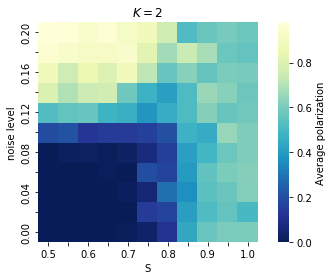

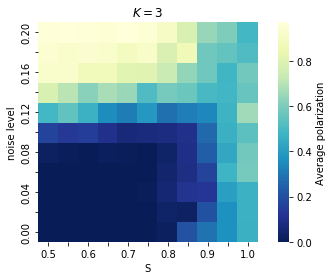

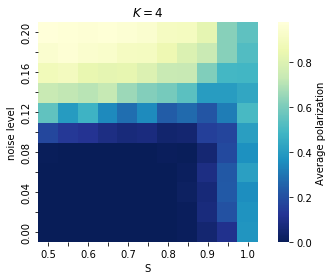

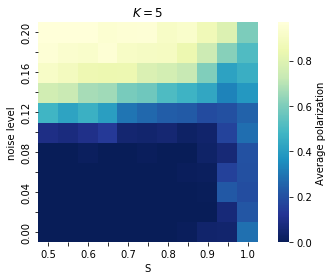

In [3]:
from complexity_analysis import plot_p_v_noise_and_k

plot_p_v_noise_and_k(ne_dir)
# Sync to {save_path}_K={K}.pdf; no need
# to set fig sizes since these are square pdfs.
# plot_p_v_noise_and_k(ne_dir, save_path='test_save_noise_comm')

We will now apply the analyses from the IC plots, which will require some development of new functions to select single `(S, K)` or `(noise_level, K)` pairs whereas before we only needed to specify `K` in order to make plots like the one below. Essentially, we will want to examine the variability in an x-y plot where the x-axis is either the magnitude of initial opinion or the noise level. 

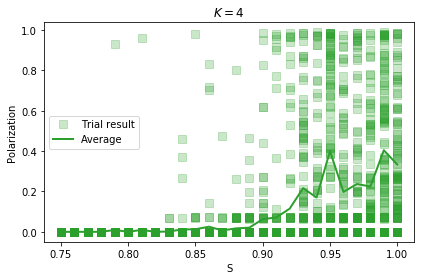

In [6]:
from complexity_analysis import plot_single_S_K
plot_single_S_K('data/ic_k234', 4)

So what we need is something that works like this that would plot the column corresponding to $S=0.5$, for example. 
```python
plot_single_param_spec('data/noise_experiment_all/', 
                       S=0.5)
```
Or this would plot the row corresponding to $\sigma=0.1$
```python

plot_single_param_spec('data/noise_experiment_all/', 
                       noise_level=0.1)
```

I'll demonstrate this first by looking at the $S=0.5$ column of the heatmap built again below for comparison.

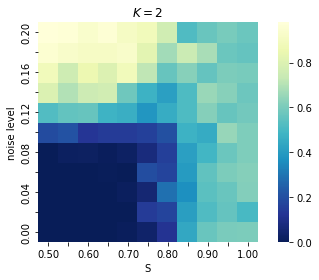

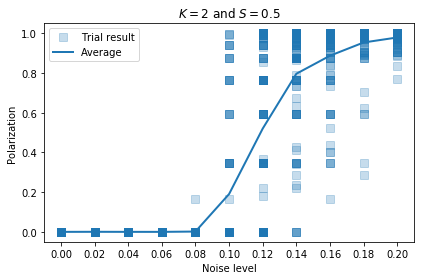

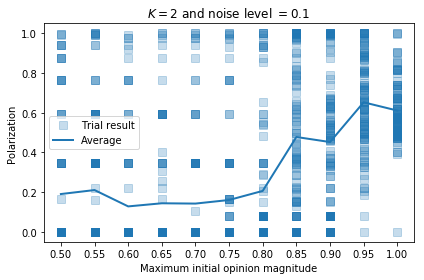

In [7]:
from complexity_analysis import plot_single_noise_param
plot_p_v_noise_and_k(ne_dir, Ks=[2])
plt.figure()
plot_single_noise_param(ne_dir, 2, S=0.5)
plt.figure()
plot_single_noise_param(ne_dir, 2, noise_level=0.10)

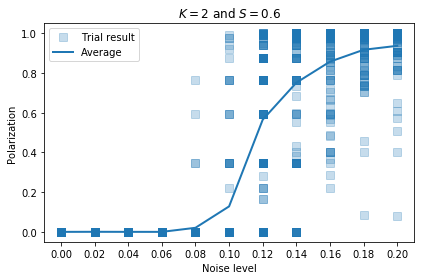

In [8]:
plot_single_noise_param(ne_dir, 2, S=0.6)

There is no value for the 0.2 noise level. This is because of NaN in the model results. I don't know why these show up right now, other than it seems to only happen with high levels of noise. I want to see if I can learn anything by finding the offending NaN. Is it a coordinate that nans out or is it the calculation of the polarization itself?

In [9]:
from complexity_analysis import _lookup_hdf, _all_final_polarizations

K = 2
hdf = _lookup_hdf(ne_dir, K=2, S=0.6, noise_level=0.2)
print(dict(hdf.attrs))

final_pols = _all_final_polarizations(hdf)
nan_idx = np.argwhere(np.isnan(final_pols))
print(nan_idx)

{'K': 2, 'S': 0.6, 'noise_level': 0.2, 'distance_metric': 'fm2011', 'n_iter_sync': 200}
[]


In [10]:
final_coords = hdf['random any-range/coords'][:, -1]
final_coords.shape

(100, 100, 2)

That's right, I was not syncing coordinates at this point. So, although this is a little unfortunate, here's the first instance of where more runs need to be done. I still can finish these plots and write up the report as Paul has asked for. I think the parallel coordinates would be good, but I just don't have the data right now. It should be as simple as running the noise experiment shell script on the cluster, which I'll do after working hours so nobody is awake to complain :)

What I'll do in the meantime is just take means and ignore nans. This will be fixed so the plots above won't even show it. I fixed it by only taking the average over final polarizations that were not NaN.

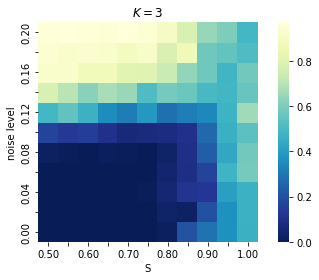

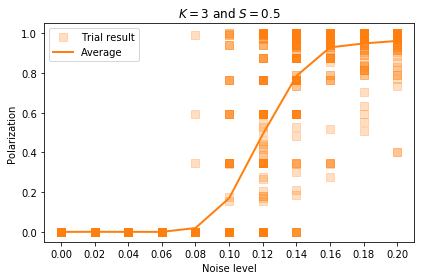

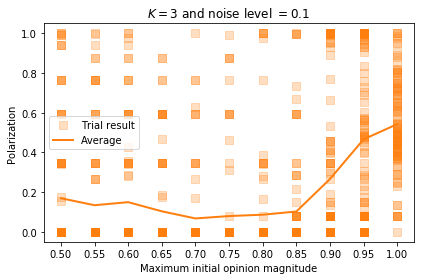

In [11]:
K = 3
plot_p_v_noise_and_k(ne_dir, Ks=[K])
plt.figure()
plot_single_noise_param(ne_dir, K, S=0.5)
plt.figure()
plot_single_noise_param(ne_dir, K, noise_level=0.10)

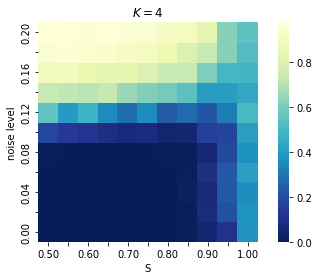

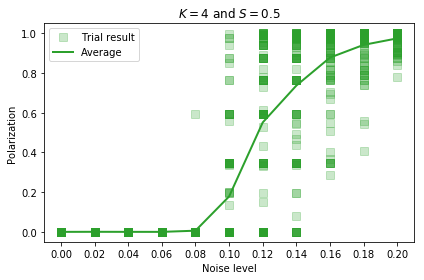

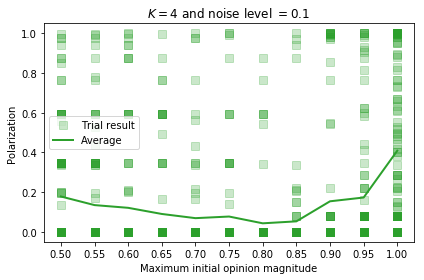

In [12]:
K = 4
plot_p_v_noise_and_k(ne_dir, Ks=[K])
plt.figure()
plot_single_noise_param(ne_dir, K, S=0.5)
plt.figure()
plot_single_noise_param(ne_dir, K, noise_level=0.10)

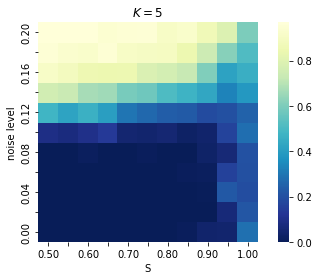

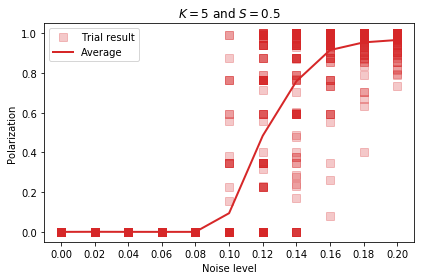

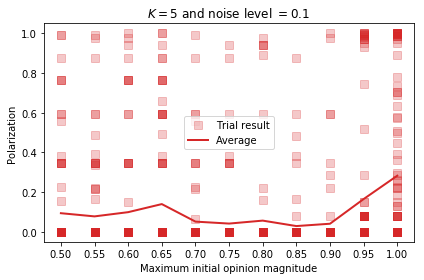

In [13]:
K = 5
plot_p_v_noise_and_k(ne_dir, Ks=[K])
plt.figure()
plot_single_noise_param(ne_dir, K, S=0.5)
plt.figure()
plot_single_noise_param(ne_dir, K, noise_level=0.10)

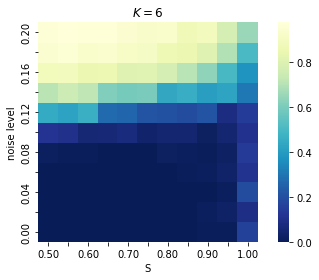

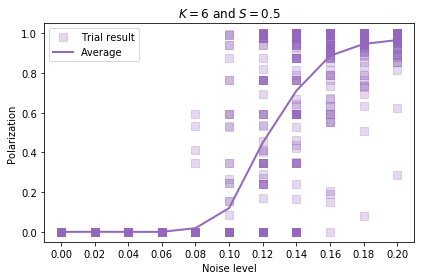

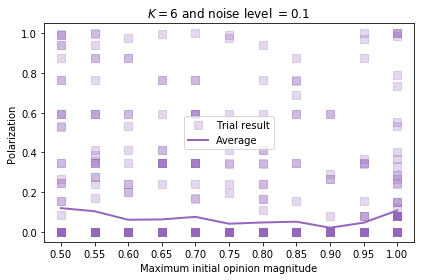

In [14]:
K = 6
plot_p_v_noise_and_k(ne_dir, Ks=[K])
plt.figure()
plot_single_noise_param(ne_dir, K, S=0.5)
plt.figure()
plot_single_noise_param(ne_dir, K, noise_level=0.10)

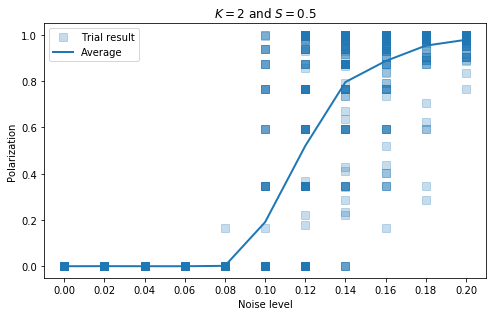

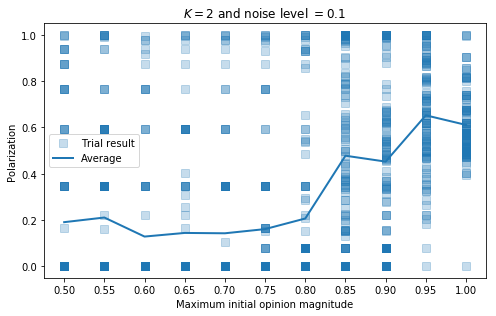

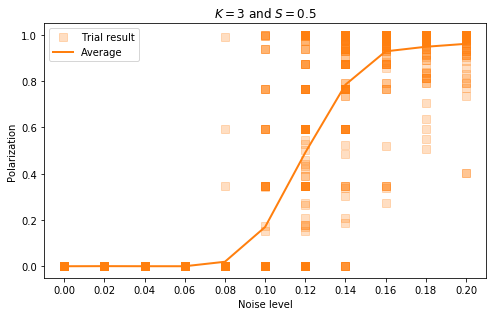

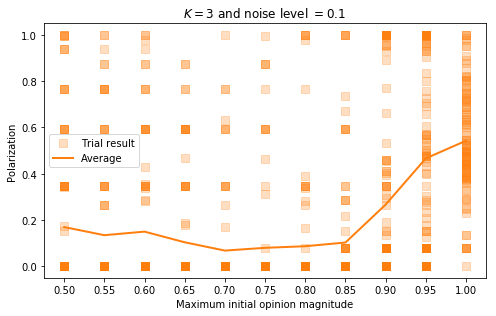

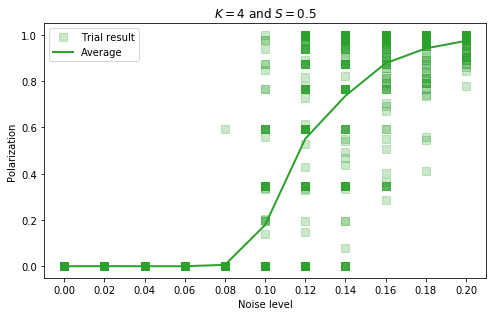

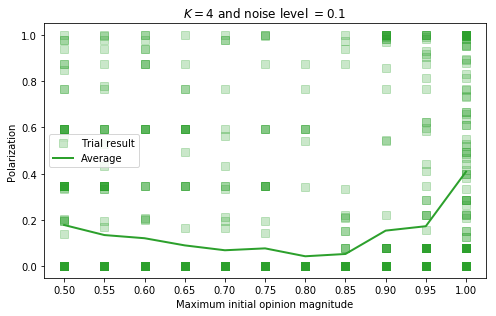

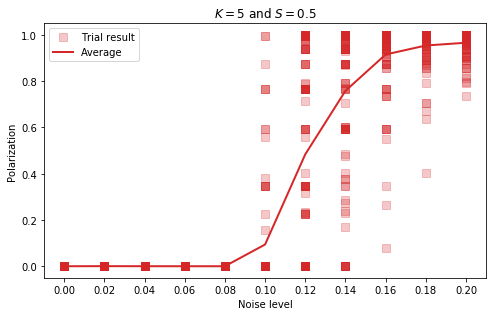

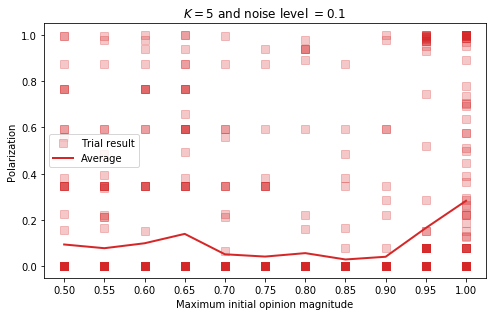

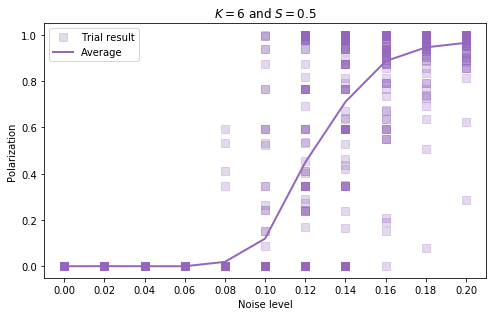

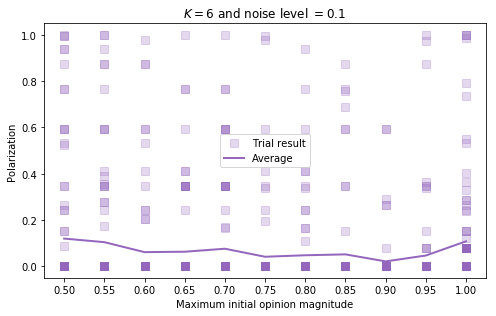

In [15]:
# Save figures to reports/Figures directory.
figdir = 'reports/Figures/'
plot_p_v_noise_and_k(ne_dir, save_path=figdir + 'noisecomm')

for K in range(2, 7):
    plot_single_noise_param(
        ne_dir, K, S=0.5, 
        save_path=figdir + 'noisecomm_S=0p5_K={}.pdf'.format(K),
        figsize=(7, 4.5))
    plot_single_noise_param(
        ne_dir, K, noise_level=0.10,
        save_path=figdir + 'noisecomm_level=0p10_K={}.pdf'.format(K),
        figsize=(7, 4.5))

Now we want to plot the time evolution in 2D for the corners of the heatmap. This will mean:
1. Look up the HDF for that parameter set.
2. Select a run at random for now. Might as well just pick the first trial.
3. Copy the 2x2 subplots, but make it a 1x4 row.
4. Save each 1x4 row independently.

{'K': 2, 'S': 0.5, 'noise_level': 0.0, 'distance_metric': 'fm2011', 'n_iter_sync': 200}
['random any-range']


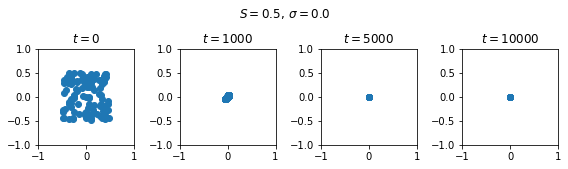

In [56]:
from complexity_analysis import _lookup_hdf

fig, axes = plt.subplots(1, 4, figsize=(8, 5))
fig.suptitle(r'$S=0.5$, $\sigma=0.0$', y=.75)  # , y=1.05, fontsize=14)

# Get the HDF we want to plot.
hdf = _lookup_hdf('data/noise_experiment', K=2, noise_level=0.0, S=0.5)
print(dict(hdf.attrs))
print(list(hdf.keys()))

# First define which time steps are desired.
tsteps = [0, 1000, 5000, 10000]
# Snapshots are taken every n_iter_sync steps.
coords = hdf['random any-range/coords'][0]
n_iter_sync = hdf.attrs['n_iter_sync']
snapshot_idxs = [tstep // n_iter_sync for tstep in tsteps]

coords.shape

for i in range(4):
    snap_idx = snapshot_idxs[i]
    axes[i].plot(coords[snap_idx, :, 0],
                 coords[snap_idx, :, 1], 'o')
    axes[i].set_xlim(-1, 1)
    axes[i].set_ylim(-1, 1)
    axes[i].set_aspect('equal')
    axes[i].set_title(r'$t={}$'.format(tsteps[i]))

Wrapped all this in a function, let's test it out...

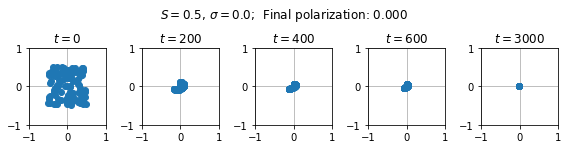

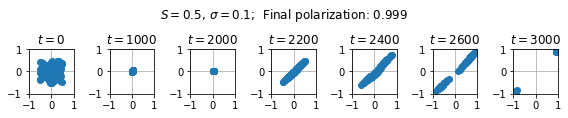

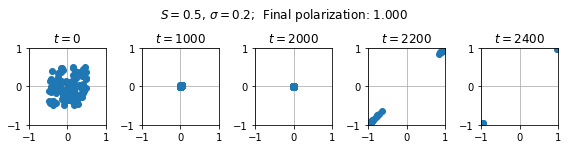

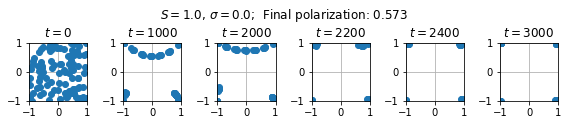

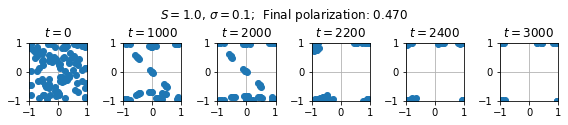

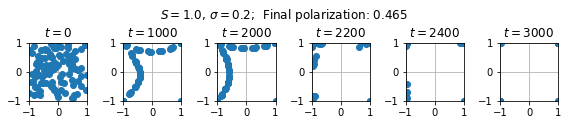

In [143]:
from complexity_analysis import plot_single_noise_example


plot_single_noise_example('data/noise_experiment', S=0.5, noise_level=0.0,
                          time_steps=[0, 200, 400, 600, 3000], save_path='noise_coords_S0p5_n0p0.pdf',
                         y_title=.87)

plot_single_noise_example('data/noise_experiment', S=0.5, 
                          noise_level=0.1, 
                          time_steps=[0, 1000, 2000, 2200, 2400, 2600, 3000],
                          trial_idx=30, y_title=.8, save_path='noise_coords_S0p5_n0p1.pdf')

plot_single_noise_example('data/noise_experiment', S=0.5, 
                          noise_level=0.2, 
                          time_steps=[0, 1000, 2000, 2200, 2400], y_title=0.87,
                          trial_idx=30, save_path='noise_coords_S0p5_n0p2.pdf')

plot_single_noise_example('data/noise_experiment', S=1.0, noise_level=0.0, 
                          time_steps=[0, 1000, 2000, 2200, 2400, 3000],
                          y_title=.8, trial_idx=12,
                          save_path='noise_coords_S1p0_n0p0.pdf')

plot_single_noise_example('data/noise_experiment', S=1.0, 
                          noise_level=0.1, 
                          time_steps=[0, 1000, 2000, 2200, 2400, 3000],
                          trial_idx=30, y_title=.8, 
                          save_path='noise_coords_S1p0_n0p1.pdf')

plot_single_noise_example('data/noise_experiment', S=1.0, 
                          noise_level=0.20, 
                          time_steps=[0, 1000, 2000, 2200, 2400, 3000],
                          y_title=.8, save_path='noise_coords_S1p0_n0p2.pdf')
# plt.savefig('test.pdf')

In [102]:
hdf = _lookup_hdf('data/noise_experiment/', K=2, S=1.0, noise_level=0.2)

trial_coords = hdf['random any-range/coords']
trial_coords.shape

(100, 51, 100, 2)